# Statistical Segmentation

Topics Covered
- SQL
- RFM Transformation
- Sampling
- Hierarichal Clustering and Dendogram

## Imports

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer

In [ ]:
sns.set()

## Read Dataset

In [ ]:
df = pd.read_csv("W106_purchases.txt", sep='\t', 
                 names=['consumer_id', 'purchase_amount', 'date_of_purchase'], 
                 parse_dates=['date_of_purchase']); df.head()

consumer_id  purchase_amount date_of_purchase
0          760             25.0       2009-11-06
1          860             50.0       2012-09-28
2         1200            100.0       2005-10-25
3         1420             50.0       2009-07-09
4         1940             70.0       2013-01-25

In [ ]:
df['year_of_purchase'] = df['date_of_purchase'].dt.year

In [ ]:
df.describe(include='all')

/tmp/ipykernel_22169/2884002236.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


consumer_id  purchase_amount     date_of_purchase  year_of_purchase
count    51243.000000     51243.000000                51243      51243.000000
unique            NaN              NaN                 1879               NaN
top               NaN              NaN  2013-12-31 00:00:00               NaN
freq              NaN              NaN                  864               NaN
first             NaN              NaN  2005-01-02 00:00:00               NaN
last              NaN              NaN  2015-12-31 00:00:00               NaN
mean    108934.547938        62.337195                  NaN       2010.869699
std      67650.610139       156.606801                  NaN          2.883072
min         10.000000         5.000000                  NaN       2005.000000
25%      57720.000000        25.000000                  NaN       2009.000000
50%     102440.000000        30.000000                  NaN       2011.000000
75%     160525.000000        60.000000                  NaN       2013.000000
max     264200.000000      4500.000000                  NaN       2015.000000

In [ ]:
max_date=df['date_of_purchase'].max()+dt.timedelta(days=1)

In [ ]:
df['days_since_purchase']=(max_date - df['date_of_purchase']).dt.days

<AxesSubplot:xlabel='date_of_purchase', ylabel='purchase_amount'>

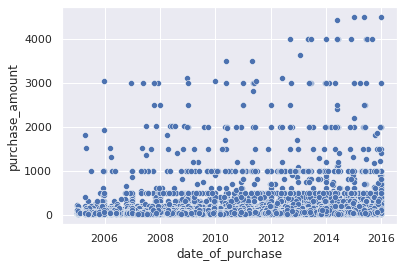

In [ ]:
sns.scatterplot(data=df, x='date_of_purchase', y='purchase_amount')

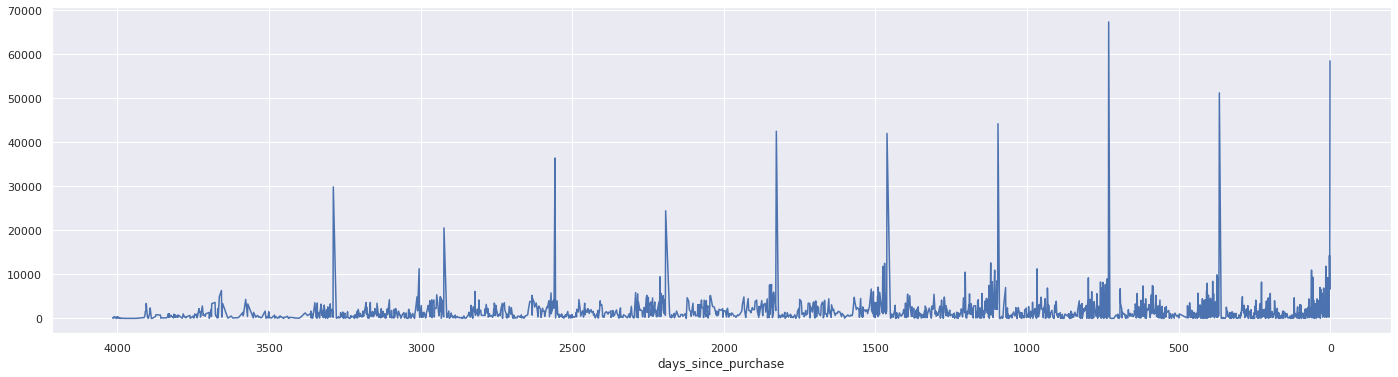

In [ ]:
df.groupby('days_since_purchase')['purchase_amount'].sum().plot.line(figsize=(24,6)).invert_xaxis()

In [ ]:
consumer_df = df.groupby('consumer_id').agg({'purchase_amount':'mean', 'year_of_purchase':'last', 'days_since_purchase':'last', 'date_of_purchase':'count'})\
.rename(columns={'purchase_amount':'monetary', 
                 'year_of_purchase':'last_purchase_year',
                 'days_since_purchase':'recency',
                 'date_of_purchase': 'frequency'})
consumer_df.head()

monetary  last_purchase_year  recency  frequency
consumer_id                                                    
10            30.000000                2005     3829          1
80            71.428571                2009     2457          7
90           115.800000                2012     1096         10
120           20.000000                2012     1401          1
130           50.000000                2005     3710          2

<AxesSubplot:xlabel='frequency', ylabel='monetary'>

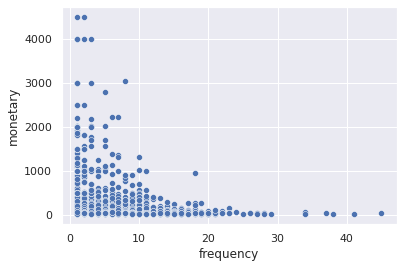

In [ ]:
sns.scatterplot(data=consumer_df,y='monetary', x='frequency')

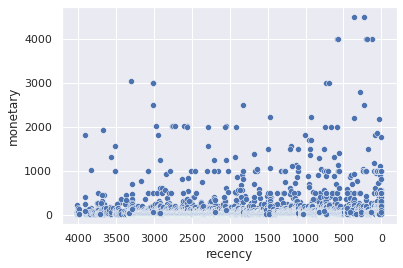

In [ ]:
sns.scatterplot(data=consumer_df,y='monetary', x='recency').invert_xaxis()

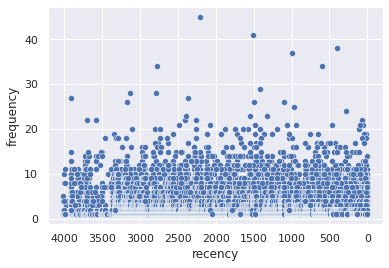

In [ ]:
sns.scatterplot(data=consumer_df,y='frequency', x='recency').invert_xaxis()

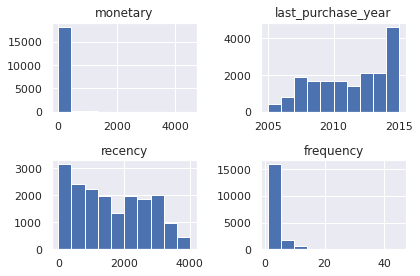

In [ ]:
consumer_df.hist()
plt.tight_layout()

<AxesSubplot:>

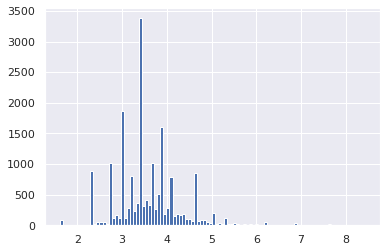

In [ ]:
np.log(consumer_df['monetary']).hist(bins=100)

<AxesSubplot:>

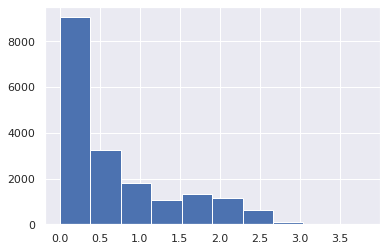

In [ ]:
np.log(consumer_df['frequency']).hist()

In [ ]:
# np.log(consumer_df['recency']).hist()

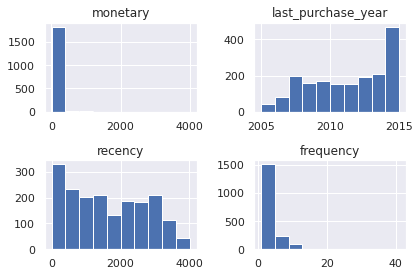

In [ ]:
consumer_df.sample(frac=0.1).hist()
plt.tight_layout()

In [ ]:
sample = consumer_df.sample(frac=0.1)

[(0.0, 10.0)]

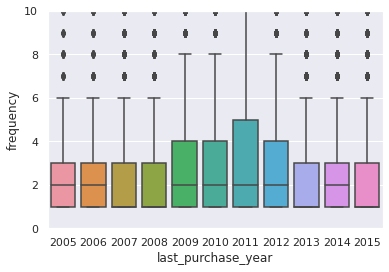

In [ ]:
sns.boxplot(data=consumer_df, x='last_purchase_year', y='frequency').set(ylim=(0,10))

[(0.0, 100.0)]

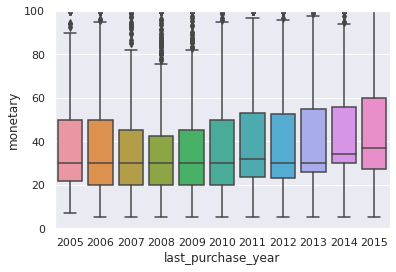

In [ ]:
sns.boxplot(data=consumer_df, x='last_purchase_year', y='monetary').set(ylim=(0,100))

## Segmentation with Hierarchal Clustering

In [ ]:
def process_df(df):
    df_cp = df.copy()
    df_cp['frequency'] = np.log1p(df_cp['frequency'])
    df_cp['monetary'] = np.log1p(df_cp['monetary'])
    return df_cp

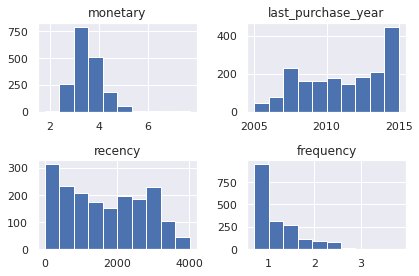

In [ ]:
process_df(sample).hist()
plt.tight_layout()

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
pipeline = make_pipeline(FunctionTransformer(process_df), StandardScaler(),  AgglomerativeClustering(distance_threshold=0, n_clusters=None))
pipeline

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function process_df at 0x116c37259e50>)),
                ('standardscaler', StandardScaler()),
                ('agglomerativeclustering',
                 AgglomerativeClustering(distance_threshold=0,
                                         n_clusters=None))])

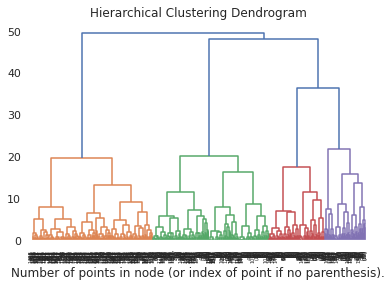

In [ ]:
pipeline.fit(sample[['recency', 'frequency', 'monetary']])
model = pipeline['agglomerativeclustering']
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=9)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
pipeline2 = make_pipeline(FunctionTransformer(process_df), StandardScaler(),  AgglomerativeClustering(n_clusters=5))
pipeline2.fit(sample[['recency', 'frequency', 'monetary']])
pipeline2

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function process_df at 0x116c37259e50>)),
                ('standardscaler', StandardScaler()),
                ('agglomerativeclustering',
                 AgglomerativeClustering(n_clusters=5))])

In [ ]:
sample['cluster'] = pipeline2.fit_predict(sample[['recency', 'frequency', 'monetary']])+1

In [ ]:
sample

monetary  last_purchase_year  recency  frequency  cluster
consumer_id                                                           
134880           10.0                2009     2192          1        1
214990           30.0                2013      731          1        4
77150            30.0                2007     3102          1        1
88000            40.0                2007     2961          1        1
163970           29.0                2014      437          5        4
...               ...                 ...      ...        ...      ...
181050           10.0                2012     1188          1        4
144260           20.0                2010     1990          1        1
155540           20.0                2011     1688          1        4
61350           103.0                2011     1476         10        2
191070           12.5                2012     1097          2        4

[1842 rows x 5 columns]

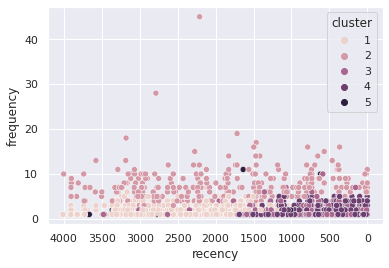

In [ ]:
sns.scatterplot(data=sample,y='frequency', x='recency', hue='cluster').invert_xaxis()

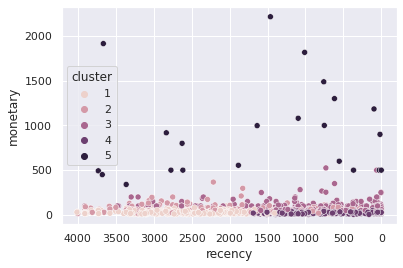

In [ ]:
sns.scatterplot(data=sample,y='monetary', x='recency', hue='cluster').invert_xaxis()

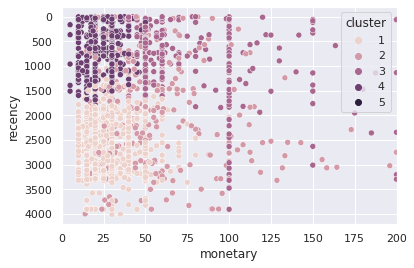

In [ ]:
ax = sns.scatterplot(data=sample,x='monetary', y='recency', hue='cluster')
ax.set_xlim(0,200)
ax.invert_yaxis()

(0.0, 200.0)

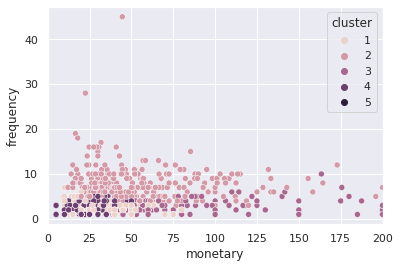

In [ ]:
ax = sns.scatterplot(data=sample,x='monetary', y='frequency', hue='cluster')
ax.set_xlim(0,200)
# ax.invert_yaxis()

In [ ]:
sample.reset_index().groupby('cluster').agg({'consumer_id':'count', 
                                             'last_purchase_year':'max', 
                                             'recency':['min','mean', 'max'], 
                                             'frequency':['min','mean', 'max'], 
                                             'monetary':['mean','sum']})

consumer_id last_purchase_year recency                    frequency  \
              count                max     min         mean   max       min   
cluster                                                                       
1               722               2013    1055  2593.411357  4012         1   
2               296               2015       1  1873.834459  4002         3   
3               316               2015       1   843.329114  3908         1   
4               486               2015       1   689.253086  1840         1   
5                22               2015       1  1616.772727  3730         1   

                         monetary                
             mean max        mean           sum  
cluster                                          
1        1.674515   7   29.465882  21274.366667  
2        7.841216  45   56.487871  16720.409733  
3        1.746835  10   85.591320  27046.857143  
4        1.668724   5   24.777778  12042.000000  
5        2.454545  11  934.168545  20551.707987

In [ ]:
sample.reset_index().groupby(['cluster', 'last_purchase_year']).agg({'consumer_id':'count',  
                                             'recency':['min','mean', 'max'], 
                                             'frequency':['min','mean', 'max'], 
                                             'monetary':['mean','sum']})

consumer_id recency                    frequency  \
                                 count     min         mean   max       min   
cluster last_purchase_year                                                    
1       2005                        27    3691  3848.851852  4012         1   
        2006                        57    3288  3325.403509  3577         1   
        2007                       182    2923  3095.049451  3272         1   
        2008                       128    2557  2687.835938  2907         1   
        2009                       126    2192  2340.039683  2550         1   
        2010                       142    1827  1999.823944  2179         1   
        2011                        42    1462  1655.428571  1815         1   
        2012                        17    1136  1307.705882  1407         2   
        2013                         1    1055  1055.000000  1055         3   
2       2005                        13    3655  3824.461538  4002         4   
        2006                        13    3288  3378.384615  3585         4   
        2007                        41    2923  3068.658537  3268         3   
        2008                        28    2557  2710.214286  2913         3   
        2009                        32    2192  2317.156250  2550         4   
        2010                        29    1827  1924.034483  2121         4   
        2011                        36    1462  1541.694444  1815         4   
        2012                        25    1096  1289.440000  1437         4   
        2013                        34     731   836.676471  1077         5   
        2014                        21     366   509.095238   702         5   
        2015                        24       1   104.000000   339         5   
3       2005                         1    3908  3908.000000  3908         2   
        2006                         6    3288  3355.833333  3478         1   
        2007                         7    2933  3067.142857  3206         1   
        2008                         3    2631  2632.000000  2633         1   
        2009                         6    2213  2359.500000  2452         1   
        2010                         7    1827  1931.714286  2086         1   
        2011                        23    1462  1597.130435  1820         1   
        2012                        45    1096  1211.911111  1435         1   
        2013                        66     731   848.803030  1071         1   
        2014                        58     366   497.224138   689         1   
        2015                        94       1    98.659574   349         1   
4       2010                         1    1840  1840.000000  1840         1   
        2011                        41    1462  1550.609756  1794         1   
        2012                        96    1096  1193.739583  1401         1   
        2013                       105     731   869.619048  1080         1   
        2014                       100     366   486.470000   686         1   
        2015                       143       1   104.937063   359         1   
5       2005                         3    3664  3690.666667  3730         1   
        2006                         1    3363  3363.000000  3363         2   
        2008                         4    2616  2712.250000  2834         1   
        2010                         1    1884  1884.000000  1884         1   
        2011                         2    1462  1549.500000  1637         7   
        2012                         1    1096  1096.000000  1096         1   
        2013                         3     752   840.666667  1011         1   
        2014                         3     367   513.333333   618         1   
        2015                         4       1    36.000000    97         1   

                                             monetary               
                                mean max         mean          sum  
cluster last_purc

<AxesSubplot:xlabel='last_purchase_year,cluster'>

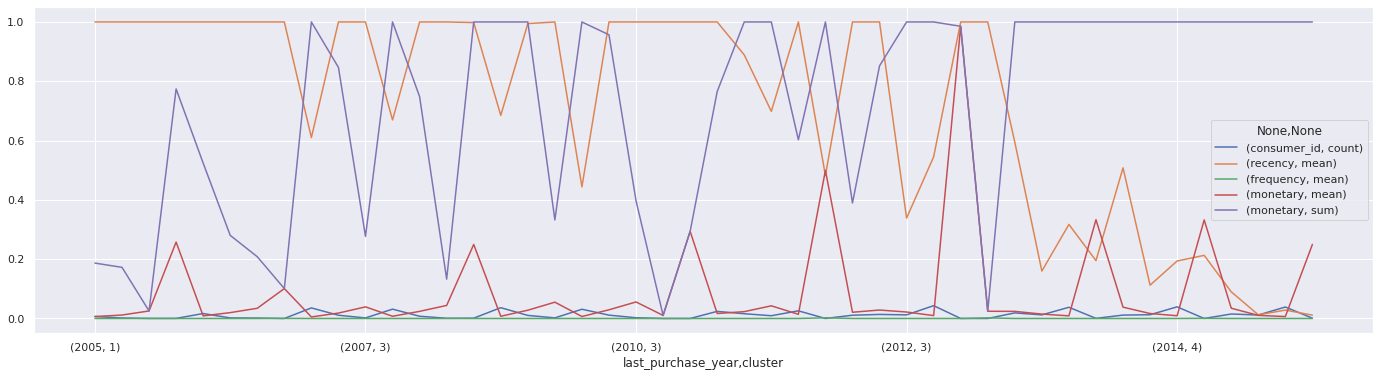

In [ ]:
sample.reset_index().groupby(['last_purchase_year', 'cluster']).agg({'consumer_id':'count', 
                                             'recency':['mean'], 
                                             'frequency':['mean',], 
                                             'monetary':['mean','sum']}).transform(lambda col : (col-col.min())/(col.max()-col.min()), axis=1).plot(figsize=(24,6))

In [ ]:
norm_sample = sample.reset_index().groupby(['last_purchase_year', 'cluster']).agg({'consumer_id':'count', 
                                             # 'recency':['mean'], 
                                             'frequency':['mean',], 
                                             'monetary':['mean', 'sum']})
norm_sample = (norm_sample - norm_sample.min())/(norm_sample.max() - norm_sample.min())
norm_sample.columns = ["_".join(a) for a in norm_sample.columns.to_flat_index()]
norm_sample.reset_index()

last_purchase_year  cluster  consumer_id_count  frequency_mean  \
0                 2005        1           0.143646        0.050725   
1                 2005        2           0.066298        0.667224   
2                 2005        3           0.000000        0.114130   
3                 2005        5           0.011050        0.114130   
4                 2006        1           0.309392        0.068078   
5                 2006        2           0.066298        0.640886   
6                 2006        3           0.027624        0.038043   
7                 2006        5           0.000000        0.114130   
8                 2007        1           1.000000        0.061455   
9                 2007        2           0.220994        0.757158   
10                2007        3           0.033149        0.048913   
11                2008        1           0.701657        0.066873   
12                2008        2           0.149171        0.750000   
13                2008        3           0.011050        0.000000   
14                2008        5           0.016575        0.028533   
15                2009        1           0.690608        0.068841   
16                2009        2           0.171271        0.802480   
17                2009        3           0.027624        0.019022   
18                2010        1           0.779006        0.080374   
19                2010        2           0.154696        0.728073   
20                2010        3           0.033149        0.146739   
21                2010        4           0.000000        0.000000   
22                2010        5           0.000000        0.000000   
23                2011        1           0.226519        0.168478   
24                2011        2           0.193370        0.846467   
25                2011        3           0.121547        0.089319   
26                2011        4           0.220994        0.005567   
27                2011        5           0.005525        0.913043   
28                2012        1           0.088398        0.187980   
29                2012        2           0.132597        0.739565   
30                2012        3           0.243094        0.063406   
31                2012        4           0.524862        0.058254   
32                2012        5           0.000000        0.000000   
33                2013        1           0.000000        0.228261   
34                2013        2           0.182320        0.778772   
35                2013        3           0.359116        0.098567   
36                2013        4           0.574586        0.082609   
37                2013        5           0.011050        0.038043   
38                2014        2           0.110497        1.000000   
39                2014        3           0.314917        0.155454   
40                2014        4           0.546961        0.105000   
41                2014        5           0.011050        0.380435   
42                2015        2           0.127072        0.784647   
43                2015        3           0.513812        0.049780   
44                2015        4           0.784530        0.084600   
45                2015        5           0.016575        0.000000   

    monetary_mean  monetary_sum  
0        0.004202      0.088562  
1        0.019645      0.081626  
2        0.050425      0.010121  
3        0.587769      0.358993  
4        0.006672      0.218032  
5        0.033544      0.117893  
6        0.060931      0.086032  
7        0.201701      0.040486  
8        0.004961      0.639219  
9        0.027358      0.326355  
10       0.063932      0.105009  
11       0.007159      0.505290  
12       0.033079      0.254228  
13       0.060931      0.041751  
14       0.415650      0.341309  
15       0.004482      0.429636  
16       0.033287      0.292247  
17       0.069860      0.096786  
18       0.007385      0.567273  
19       0.027410      0.230403  

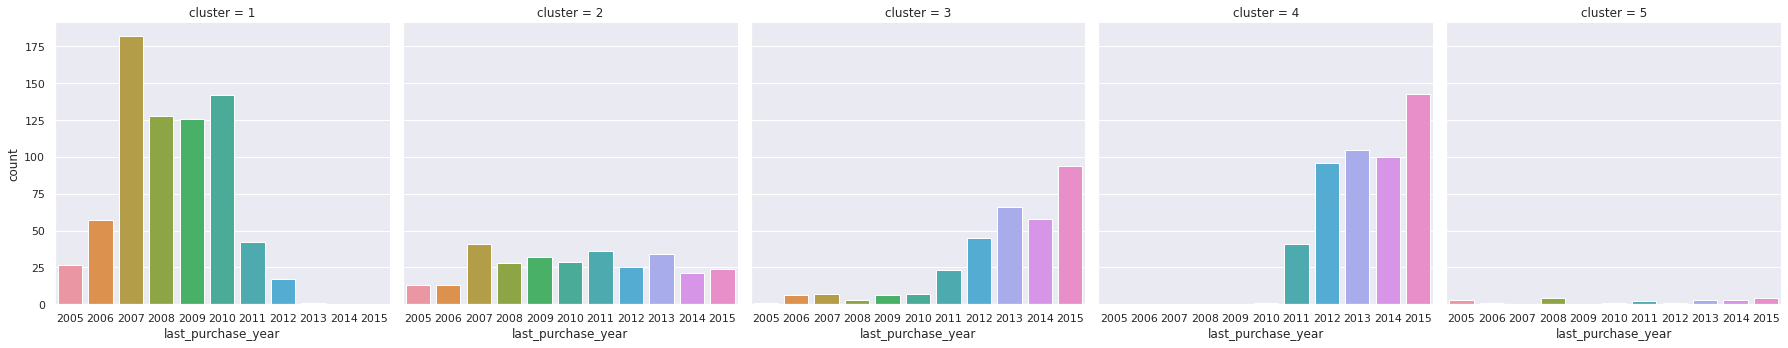

In [ ]:
sns.catplot(x='last_purchase_year',  col='cluster', col_wrap=5,  kind='count',ci='sd', data=sample.reset_index())

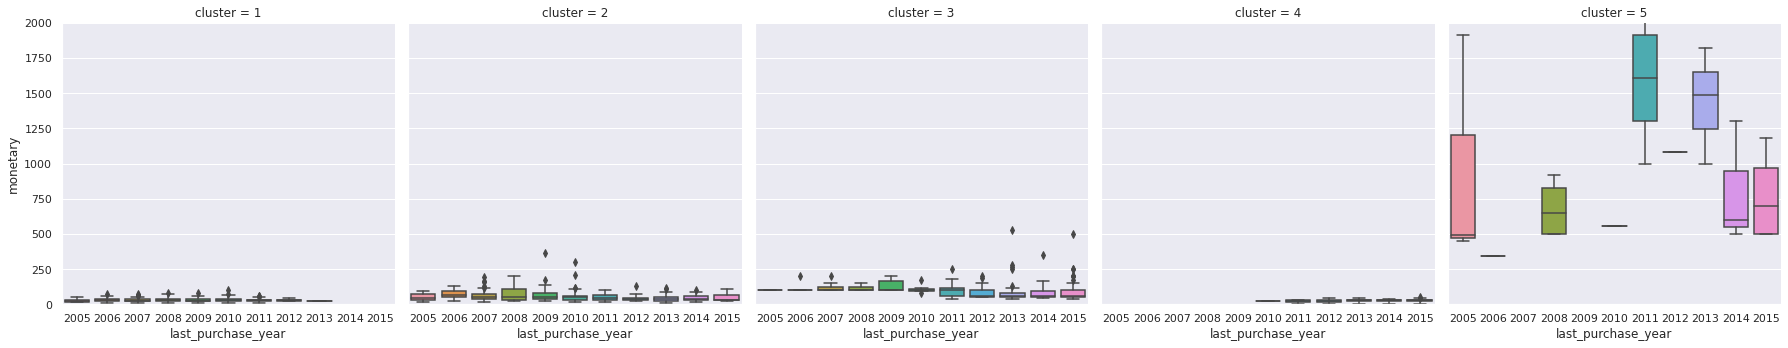

In [ ]:
sns.catplot(x='last_purchase_year', y='monetary', col='cluster',col_wrap=5, kind='box',ci='sd', data=sample).set( ylim=(0,2000))

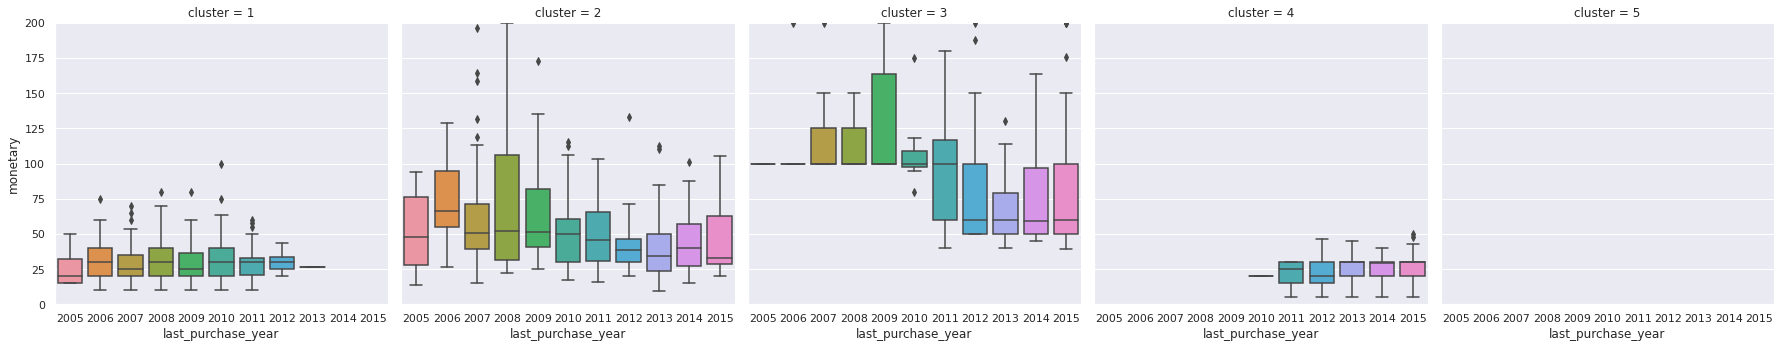

In [ ]:
sns.catplot(x='last_purchase_year', y='monetary', col='cluster',col_wrap=5, kind='box',ci='sd', data=sample).set( ylim=(0,200))

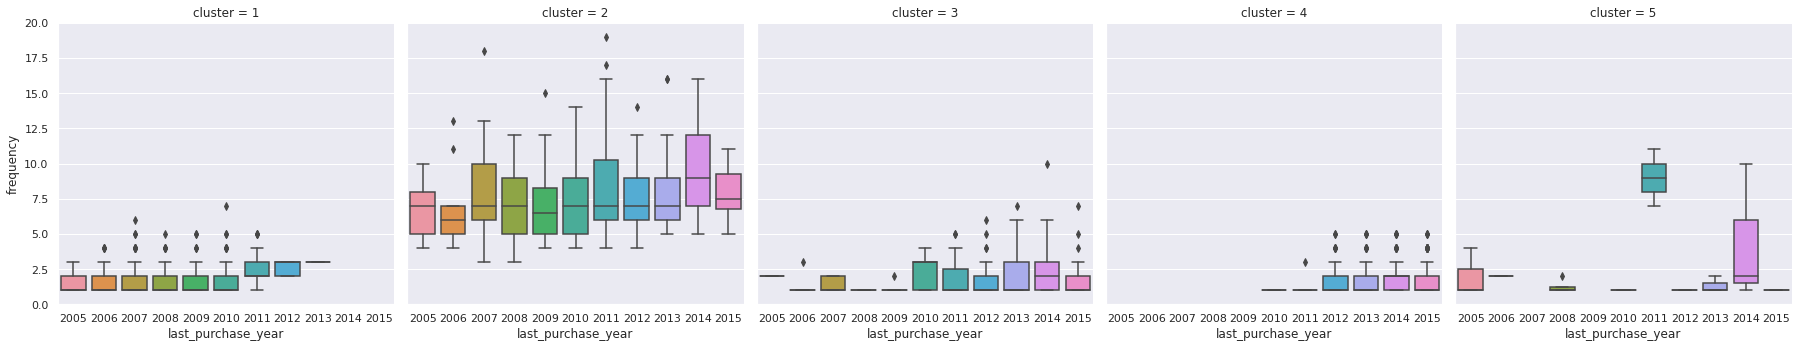

In [ ]:
sns.catplot(x='last_purchase_year', y='frequency', col='cluster',col_wrap=5, kind='box',ci='sd', data=sample).set( ylim=(0,20))

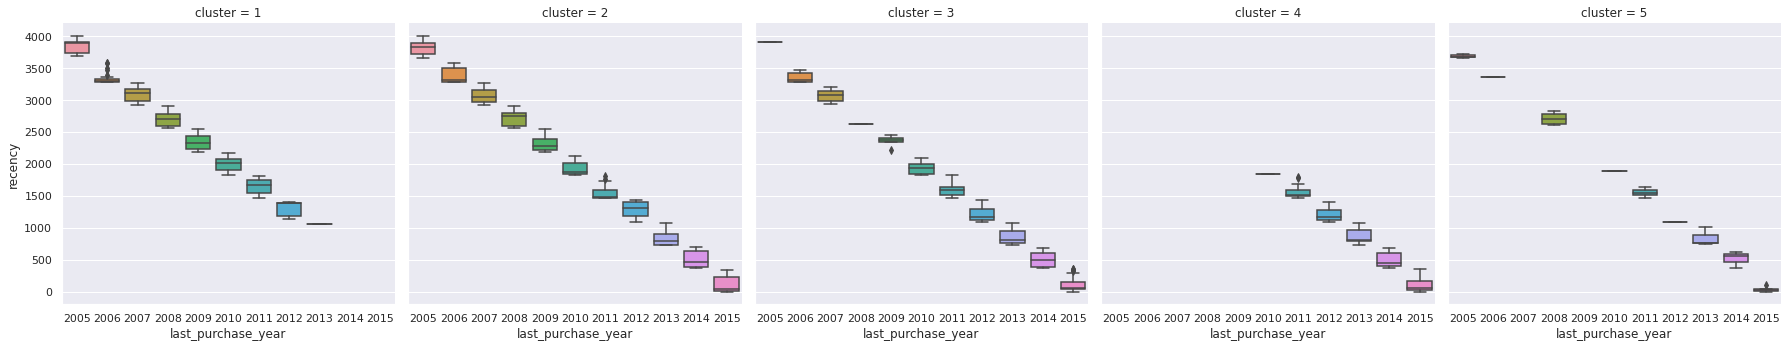

In [ ]:
sns.catplot(x='last_purchase_year', y='recency', col='cluster',col_wrap=5, kind='box',ci='sd', data=sample)

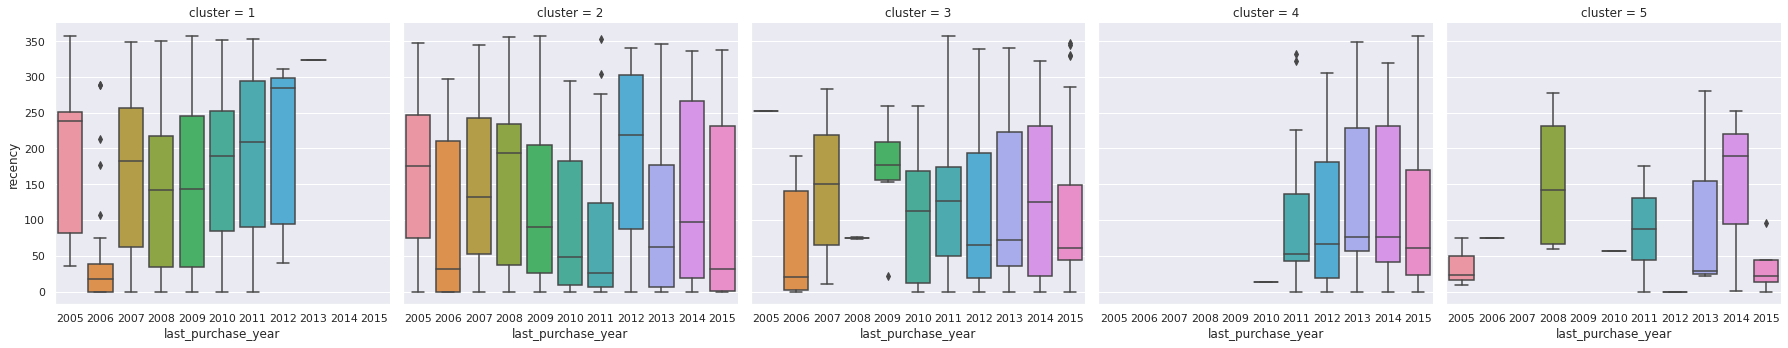

In [ ]:
sample_cp = sample.copy()
sample_cp['recency'] = sample['recency']-sample.groupby('last_purchase_year')['recency'].transform('min')
sns.catplot(x='last_purchase_year', y='recency', col='cluster',col_wrap=5, kind='box',ci='sd', data=sample_cp)

In [ ]:
sample

monetary  last_purchase_year  recency  frequency  cluster
consumer_id                                                           
134880           10.0                2009     2192          1        1
214990           30.0                2013      731          1        4
77150            30.0                2007     3102          1        1
88000            40.0                2007     2961          1        1
163970           29.0                2014      437          5        4
...               ...                 ...      ...        ...      ...
181050           10.0                2012     1188          1        4
144260           20.0                2010     1990          1        1
155540           20.0                2011     1688          1        4
61350           103.0                2011     1476         10        2
191070           12.5                2012     1097          2        4

[1842 rows x 5 columns]